In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(caret))
suppressMessages(library(patchwork))
suppressMessages(library(PRROC))
suppressMessages(library(MetBrewer))

In [ ]:
SPATIAL_PATTERNS = c("human_DLPFC_151508",
                     "human_DLPFC_151674",
                     "mouse_cerebellum",
                     "mouse_coronal_slices",
                     "breast_tumor")

In [14]:
df <- read.csv("../benchmarking/log_fold_change/SpatialDE/human_DLPFC_151508_logfc_0.5.csv", row.names=1)

In [5]:
aupr <- lapply(c(0.5, 1, 1.5, 2), function(i){
    df <- read.csv(glue::glue("../benchmarking/log_fold_change/SPARK-X/human_DLPFC_151508_logfc_{i}.csv"), row.names=1)
    if(method == "Sepal"){
        pr <- pr.curve(scores.class0=df$sepal_score, weights.class0=df$spatially_variable, curve=TRUE)
    } else{
        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
        pr <- pr.curve(scores.class0=-df$adjusted_pvalue, weights.class0=df$spatially_variable, curve=TRUE)
    }
    aupr <- pr$auc.integral
    return(aupr)
    
})%>% unlist() %>% as.data.frame()

ERROR: Error in read.table(file = file, header = header, sep = sep, quote = quote, : missing values in 'row.names' are not allowed


Here, we compare the performance of each method using the simulated SVGs. The idea is to compare their accuracy, sensitivity, and specificity.

In [2]:
get_aupr <- function(method){ 
    df_list = list()
    for(spatial_pattern in SPATIAL_PATTERNS){
        aupr <- lapply(c(0.5, 1, 1.5, 2), function(i){
                df <- read.csv(glue::glue("../benchmarking/log_fold_change/{method}/{spatial_pattern}_logfc_{i}.csv"), row.names=1)
                if(method == "Sepal"){
                        pr <- pr.curve(scores.class0=df$sepal_score, weights.class0=df$spatially_variable, curve=TRUE)
                    } else{
                        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
                        pr <- pr.curve(scores.class0=-df$adjusted_pvalue, weights.class0=df$spatially_variable, curve=TRUE)
                    }
                aupr <- pr$auc.integral
                return(aupr)
            
        })%>% unlist() %>%as.data.frame()
}

In [3]:
get_confusion_matrix <- function(method, i){
    df <- read.csv(glue::glue("../benchmarking/simulated_svgs/{method}/rep_{i}.csv"), row.names=1)
    
    if(method == "Sepal"){
        # for Sepal method, we select the top 50 genes as SVGs based on sepal score
        df$pred <- ifelse(rank(-df$sepal_score) <= 50, 1, 0)
    
    }else{
        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
        df$pred = ifelse(df$adjusted_pvalue < 0.05, 1, 0) 
    
    }
    
    df$pred <- as.factor(df$pred)
    df$spatially_variable <- as.factor(df$spatially_variable)
    
    cm <- confusionMatrix(data=df$pred, reference=df$spatially_variable, mode="everything", positive = "1")
    
    return(cm)
}

In [4]:
get_accuracy <- function(method){    
    acc <- lapply(c(0:9), function(i){
        cm <- get_confusion_matrix(method = method, i = i)
        
        # Access the overall accuracy
        accuracy <- cm$overall[1]
        return(accuracy)
        
    }) %>% unlist() %>%as.data.frame()
    
    colnames(acc) <- c("accuracy")
    acc$method <- method
    
    return(acc)

}

In [5]:
get_sensitivity <- function(method){    
    sensitivity <- lapply(c(0:9), function(i){
        cm <- get_confusion_matrix(method = method, i = i)
        return(cm$byClass[c("Sensitivity")])
    
    }) %>% unlist() %>%as.data.frame()
    
    colnames(sensitivity) <- c("sensitivity")
    sensitivity$method <- method
    
    return(sensitivity)

}

In [6]:
get_specificity <- function(method){    
    specificity <- lapply(c(0:9), function(i){
        cm <- get_confusion_matrix(method = method, i = i)
        return(cm$byClass[c("Specificity")])
    
    }) %>% unlist() %>%as.data.frame()
    
    colnames(specificity) <- c("specificity")
    specificity$method <- method
    
    return(specificity)

}

In [8]:
method_list = c("MoranI", "scGCO", "SpatialDE", "SOMDE", "SPARK", "SPARK-X", "Spanve", "SpaGCN", "Sepal", "nnSVG", "BOOST-GP")
method_list = c("SPARK-X")

df_aupr <- lapply(method_list, 
                 function(method){return(get_aupr(method))}) %>% 
    Reduce(rbind, .)

df_acc <- lapply(method_list, 
                 function(method){return(get_accuracy(method))}) %>% 
    Reduce(rbind, .)

df_sen <- lapply(method_list, 
                 function(method){return(get_sensitivity(method))}) %>% 
    Reduce(rbind, .)

df_spe <- lapply(method_list, 
                 function(method){return(get_specificity(method))}) %>% 
    Reduce(rbind, .)

df_aupr_mean <- df_aupr %>%
    group_by(method) %>%
    summarise(mean = mean(aupr), sd = sd(aupr))

df_acc_mean <- df_acc %>%
    group_by(method) %>%
    summarise(mean = mean(accuracy), sd = sd(accuracy))

df_sen_mean <- df_sen %>%
    group_by(method) %>%
    summarise(mean = mean(sensitivity), sd = sd(sensitivity))

df_spe_mean <- df_spe %>%
    group_by(method) %>%
    summarise(mean = mean(specificity), sd = sd(specificity))

In [25]:
df_sen_mean

method,mean,sd
<chr>,<dbl>,<dbl>
BOOST-GP,0.050,0.03162278
MoranI,1.000,0.00000000
SOMDE,0.982,0.01475730
SPARK,1.000,0.00000000
SPARK-X,0.990,0.01414214
Sepal,0.156,0.04299871
SpaGCN,0.894,0.11548930
Spanve,0.716,0.06168018
SpatialDE,1.000,0.00000000


In [9]:
cols=ArchR:::ArchRPalettes$stallion
cols

1         2         3         4         5         6         7         8 
"#D51F26" "#272E6A" "#208A42" "#89288F" "#F47D2B" "#FEE500" "#8A9FD1" "#C06CAB" 
       19        10        11        12        13        14        15        16 
"#E6C2DC" "#90D5E4" "#89C75F" "#F37B7D" "#9983BD" "#D24B27" "#3BBCA8" "#6E4B9E" 
       17        18         9        20 
"#0C727C" "#7E1416" "#D8A767" "#3D3D3D"

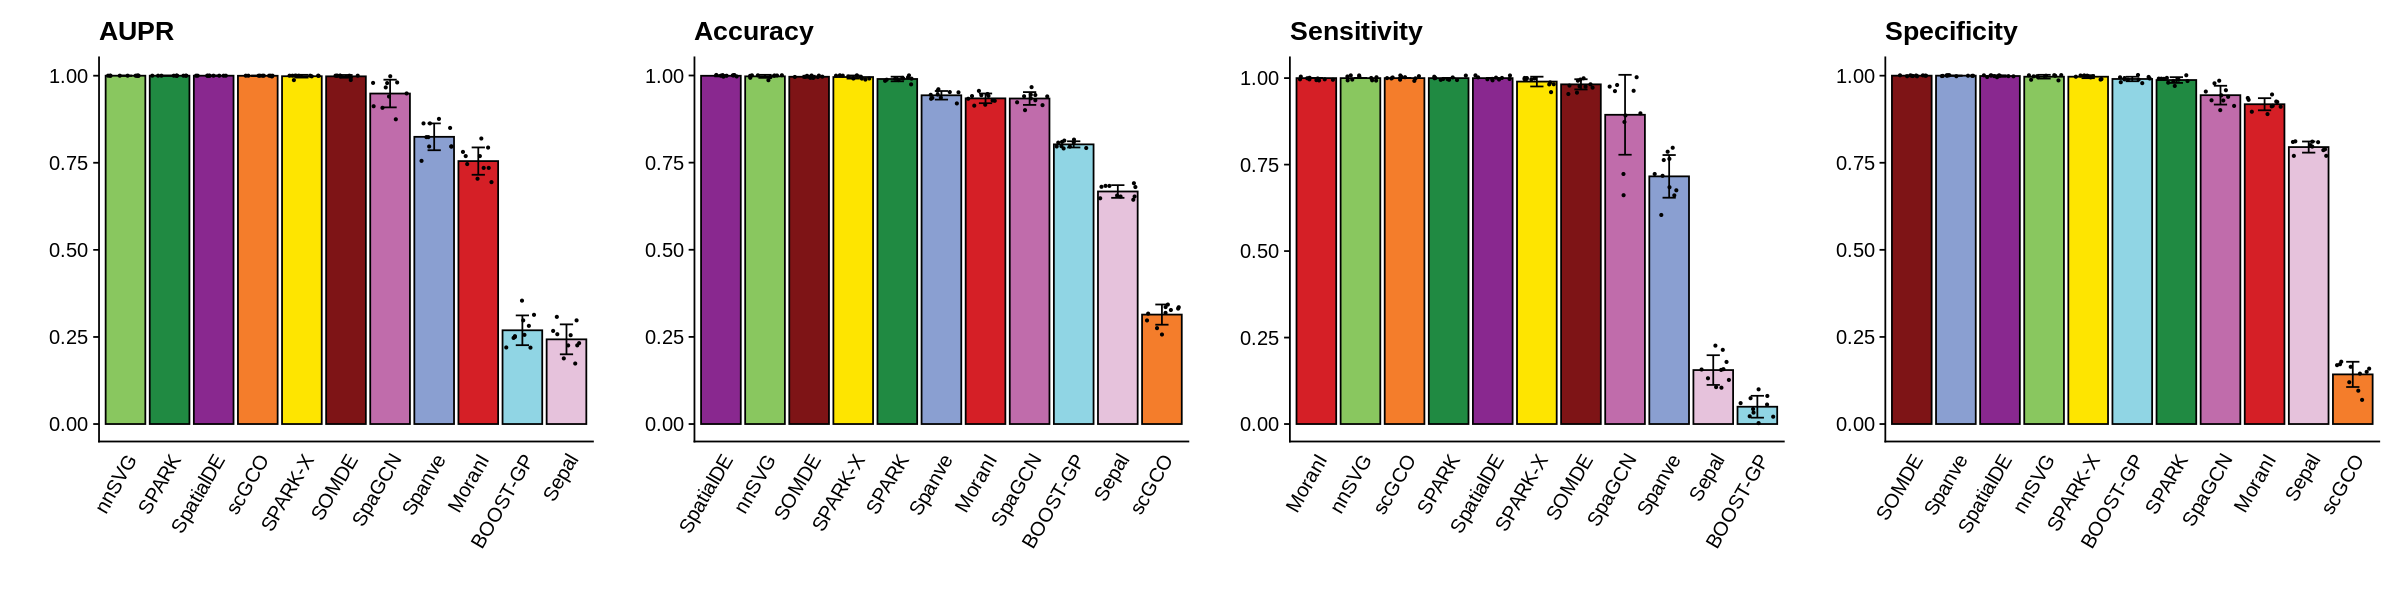

In [20]:
options(repr.plot.height = 5, repr.plot.width = 20)

cols <- c("MoranI" = "#D51F26",
         "SOMDE" = "#7E1416",
         "SPARK" = "#208A42",
         "SpatialDE" = "#89288F",
         "scGCO" = "#F47D2B",
         "SPARK-X" = "#FEE500",
         "Spanve" = "#8A9FD1",
         "SpaGCN" = "#C06CAB",
         "Sepal" = "#E6C2DC",
         "BOOST-GP" = "#90D5E4",
         "nnSVG" = "#89C75F")

p1 <- ggplot(data=df_aupr_mean, aes(x = reorder(method, -mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_jitter(data=df_aupr, aes(x = method, y = aupr), size=0.5) +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("AUPR") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.x = element_blank(),
         axis.text.x = element_text(angle=60, hjust=1))

p2 <- ggplot(data=df_acc_mean, aes(x = reorder(method, -mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_jitter(data=df_acc, aes(x = method, y = accuracy), size=0.5) +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("Accuracy") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.x = element_blank(),
         axis.text.x = element_text(angle=60, hjust=1))

p3 <- ggplot(data=df_sen_mean, aes(x = reorder(method, -mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_jitter(data=df_sen, aes(x = method, y = sensitivity), size=0.5) +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("Sensitivity") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.x = element_blank(),
         axis.text.x = element_text(angle=60, hjust=1))

p4 <- ggplot(data=df_spe_mean, aes(x = reorder(method, -mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_jitter(data=df_spe, aes(x = method, y = specificity), size=0.5) +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("Specificity") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.x = element_blank(),
         axis.text.x = element_text(angle=60, hjust=1))

p <- patchwork::wrap_plots(p1, p2, p3, p4, nrow=1)
print(p)

In [21]:
ggsave("aupr.pdf", plot=p1, height = 4, width = 5)
ggsave("accuracy.pdf", plot=p2, height = 4, width = 5)
ggsave("sensitivity.pdf", plot=p3, height = 4, width = 5)
ggsave("specificity.pdf", plot=p4, height = 4, width = 5)